# Machine Fault Detection and Monitoring System

This notebook processes and analyzes time-domain signals for fault detection in rotating machinery. It includes steps for data parsing, feature extraction, and visualization to aid in diagnostics.

## Importing Required Libraries

In [3]:
import os
import numpy as np
import pandas as pd
from src.feature_extraction.time_domain import TimeDomainFeatures
from src.feature_extraction.frequency_domain import FrequencyDomainFeatures
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "1"

INFO: Logger initialized for TimeDomainFeatures
INFO: Logger initialized for FrequencyDomainFeatures


In [4]:
def list_channel_files(directory_path):
    """
    List all files in 'TIME SIGNAL' channels for each main folder.

    Args:
        directory_path (str): The path to the root directory.

    Returns:
        dict: A dictionary containing lists of files for each channel in 'TIME SIGNAL' of every main folder.
    """
    channel_files = {}

    try:
        print(f"Starting directory scan: {directory_path}\n")

        # List all main folders in the directory
        main_folders = [entry for entry in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, entry))]
        print(f"Found {len(main_folders)} main folders.\n")

        for main_folder in main_folders:
            main_folder_path = os.path.join(directory_path, main_folder)
            print(f"Processing main folder: {main_folder}")

            # Locate 'TIME SIGNAL' folder
            time_signal_path = os.path.join(main_folder_path, "TIME SIGNAL")
            if os.path.exists(time_signal_path):
                print(f"  Found 'TIME SIGNAL' folder in {main_folder}")

                # List all channels in 'TIME SIGNAL'
                channels = [entry for entry in os.listdir(time_signal_path) if os.path.isdir(os.path.join(time_signal_path, entry))]
                print(f"  Found {len(channels)} channels in 'TIME SIGNAL' folder.")

                for channel in channels:
                    channel_path = os.path.join(time_signal_path, channel)

                    # List files in the channel
                    files = [os.path.join(channel_path, file) for file in os.listdir(channel_path) if os.path.isfile(os.path.join(channel_path, file))]
                    file_count = len(files)

                    key = f"{main_folder} - TIME SIGNAL - {channel}"
                    channel_files[key] = files

                    print(f"    Channel '{channel}' contains {file_count} files.")

            else:
                print(f"  'TIME SIGNAL' folder not found in {main_folder}. Skipping...")

        print("\nDirectory scan complete.")
    except Exception as e:
        print(f"Error during directory scanning: {e}")

    return channel_files


In [5]:
normal_files_dict = list_channel_files(r"C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM")
unbalance_files_dict = list_channel_files(r"C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM")

Starting directory scan: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM

Found 4 main folders.

Processing main folder: MOTOR DRIVE END
  Found 'TIME SIGNAL' folder in MOTOR DRIVE END
  Found 2 channels in 'TIME SIGNAL' folder.
    Channel 'CHANNEL 1' contains 40 files.
    Channel 'CHANNEL 2' contains 40 files.
Processing main folder: MOTOR FREE END
  Found 'TIME SIGNAL' folder in MOTOR FREE END
  Found 2 channels in 'TIME SIGNAL' folder.
    Channel 'CHANNEL 1' contains 40 files.
    Channel 'CHANNEL 2' contains 40 files.
Processing main folder: ROTOR DRIVEN END
  Found 'TIME SIGNAL' folder in ROTOR DRIVEN END
  Found 2 channels in 'TIME SIGNAL' folder.
    Channel 'CHANNEL 1' contains 40 files.
    Channel 'CHANNEL 2' contains 40 files.
Processing main folder: ROTOR FREE END
  Found 'TIME SIGNAL' folder in ROTOR FREE END
  Found 2 channels in 'TIME SIGNAL' folder.
    Channel 'CHANNEL 1' contains 40 files.
    Channel 'CHANN

## File Parsing and Metadata Extraction

In [7]:
def parse_file(filepath):
    """
    Parse a file to extract metadata and signal values.

    Args:
        filepath (str): The path to the file to be parsed.

    Returns:
        tuple: A dictionary of metadata and a list of signal values.
    """
    metadata = {}
    signal_values = []

    try:
        print(f"Starting to parse file: {filepath}\n")

        with open(filepath, 'r') as file:
            line_count = 0
            for line in file:
                line_count += 1
                line = line.strip()
                if line.startswith('%'):
                    if ':' in line:
                        key, value = line.split(':', 1)
                        value = value.strip().lstrip('=')
                        key = key.strip('% ').strip()
                        metadata[key] = value
                        print(f"Extracted metadata - {key}: {value}")
                elif line:  # Non-empty line
                    try:
                        signal_values.append(float(line))
                    except ValueError:
                        print(f"Skipping invalid line at {line_count}: {line}")

        print(f"\nFinished parsing file: {filepath}")
        print(f"Metadata extracted: {len(metadata)} items")
        print(f"Signal values extracted: {len(signal_values)} items\n")

    except FileNotFoundError:
        print(f"Error: File not found: {filepath}")
    except Exception as e:
        print(f"Error occurred while parsing file {filepath}: {e}")

    return metadata, signal_values


In [8]:
def calculate_sampling_rate(metadata):
    """
    Calculate the sampling rate from the given metadata.

    Args:
        metadata (dict): Metadata containing 'NoOfItems', 'Min_X', and 'Max_X'.

    Returns:
        float: Sampling rate in Hz.
    """
    # Extracting necessary values
    no_of_items = int(metadata['NoOfItems'].strip())
    min_x = float(metadata['Min_X'].strip())
    max_x = float(metadata['Max_X'].strip())
    
    # Calculating the sampling rate
    duration = max_x - min_x
    if duration == 0:
        raise ValueError("Duration cannot be zero.")
    
    sampling_rate = no_of_items / duration
    return sampling_rate

In [9]:
normal_files = [[normal_files_dict[key][i] for key in normal_files_dict.keys()] for i in range(len(normal_files_dict['MOTOR DRIVE END - TIME SIGNAL - CHANNEL 1']))]
unbalance_files = [[unbalance_files_dict[key][i] for key in unbalance_files_dict.keys()] for i in range(len(unbalance_files_dict['MOTOR DRIVEN END - TIME SIGNAL - CHANNEL 1']))]

In [10]:
meta_data,signal = parse_file(normal_files[0][0])
sampling_rate = calculate_sampling_rate(meta_data)

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_02_44) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:02:44
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_02_44) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items



## Signal Feature Extraction

In [12]:
time_features = TimeDomainFeatures(signal).all_features()
frequency_features = FrequencyDomainFeatures(signal,sampling_rate=sampling_rate).all_features()

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


In [13]:
feature_list = list(time_features.keys())+list(frequency_features.keys())
feature_names = []
for i in range(len(normal_files[0])):
    for ele in feature_list:
        feature_names.append(str(i)+'-'+ele)
feature_names

['0-1st Hjorth parameter (activity)',
 '0-2nd Hjorth parameter (mobility)',
 '0-3rd Hjorth parameter (complexity)',
 '0-Absolute Average Value',
 '0-Crest Factor',
 '0-Impulse Factor (IF)',
 '0-Kurtosis Factor',
 '0-Maximum',
 '0-Mean',
 '0-Minimum',
 '0-Peak-to-Peak',
 '0-Root Mean Square (RMS)',
 '0-Shape Factor (waveform factor)',
 '0-Skewness',
 '0-Standard Deviation',
 '0-Variance',
 '0-Zero Crossings',
 '0-Entropy Estimation',
 '0-Mean Frequency (Hz)',
 '0-Mean Square Frequency (Hz^2)',
 '0-Root Mean Square Frequency (Hz)',
 '0-Median Frequency (Hz)',
 '0-Variance of Frequency (Hz^2)',
 '0-Root Variance Frequency (Hz)',
 '0-Spectral Entropy',
 '0-Spectral Skewness',
 '0-Spectral Kurtosis',
 '0-Energy',
 '0-Residual Energy',
 '1-1st Hjorth parameter (activity)',
 '1-2nd Hjorth parameter (mobility)',
 '1-3rd Hjorth parameter (complexity)',
 '1-Absolute Average Value',
 '1-Crest Factor',
 '1-Impulse Factor (IF)',
 '1-Kurtosis Factor',
 '1-Maximum',
 '1-Mean',
 '1-Minimum',
 '1-Peak-

In [14]:
normal_all_features = []
for i in range(len(normal_files)):
    feature_row = []
    for j in range(len(normal_files[0])):
        meta_data,signal = parse_file(normal_files[i][j])
        sampling_rate = calculate_sampling_rate(meta_data)
        feature_row=feature_row+list(TimeDomainFeatures(signal).all_features().values())+list(FrequencyDomainFeatures(signal,sampling_rate=sampling_rate).all_features().values())
    normal_all_features.append(feature_row)

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_02_44) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:02:44
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_02_44) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_18_32) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:18:32
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_18_32) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_54_45) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 11:54:45
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_54_45) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_55_23) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 11:55:23
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_55_23) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 2\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_04_05) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:04:05
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 2\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_04_05) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 2\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_04_21) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:04:21
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 2\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_04_21) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_34_40) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:34:40
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_34_40) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_34_56) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:34:56
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_34_56) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_23_12) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:23:12
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_23_12) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_05_58) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:05:58
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_05_58) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_59_16) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 11:59:16
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_59_16) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_59_46) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 11:59:46
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 11_59_46) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_07_07) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:07:07
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_07_07) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_07_24) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:07:24
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_07_24) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_37_39) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:37:39
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_37_39) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_02_32) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:02:32
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_02_32) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_08_37) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:08:37
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_08_37) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_09_14) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:09:14
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_09_14) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_04_39) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:04:39
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_04_39) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_05_05) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:05:05
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_05_05) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_10_28) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:10:28
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_10_28) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_31_00) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:31:00
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_31_00) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_11_46) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:11:46
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_11_46) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_12_02) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 17:12:02
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR DRIVE END\TIME SIGNAL\CHANNEL 1\M-003.02  MOTOR DE_ 2 channel vib (10-12-2024 17_12_02) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Syst

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_41_25) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:41:25
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_41_25) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_41_41) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:41:41
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_41_41) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_35_46) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:35:46
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_35_46) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_36_14) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:36:14
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-005.04  ROTOR FE_ 2 channel vib (11-12-2024 12_36_14) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_42_47) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:42:47
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_42_47) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_12_22) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:12:22
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-005.03  ROTOR DE_ 2 channel vib (11-12-2024 12_12_22) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring Sy

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.


Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_44_26) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:44:26
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_44_26) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_44_42) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 10-DEC-24 16:44:42
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS NORMAL 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-003.01  MOTOR FE_ 2 channel vib (10-12-2024 16_44_42) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System

INFO: Time-domain signal detected. Performing FFT.


In [15]:
# Convert 2D list to a DataFrame
all_features = pd.DataFrame(normal_all_features, columns=feature_names)

# Preview the dataset
print(all_features.info())
print(all_features.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Columns: 232 entries, 0-1st Hjorth parameter (activity) to 7-Residual Energy
dtypes: float64(224), int64(8)
memory usage: 72.6 KB
None
       0-1st Hjorth parameter (activity)  0-2nd Hjorth parameter (mobility)  \
count                          40.000000                          40.000000   
mean                            1.725860                           0.358786   
std                             0.162974                           0.027627   
min                             1.455338                           0.322480   
25%                             1.577435                           0.333141   
50%                             1.674341                           0.357368   
75%                             1.891869                           0.382429   
max                             1.975584                           0.423832   

       0-3rd Hjorth parameter (complexity)  0-Absolute Average Value  \
count      

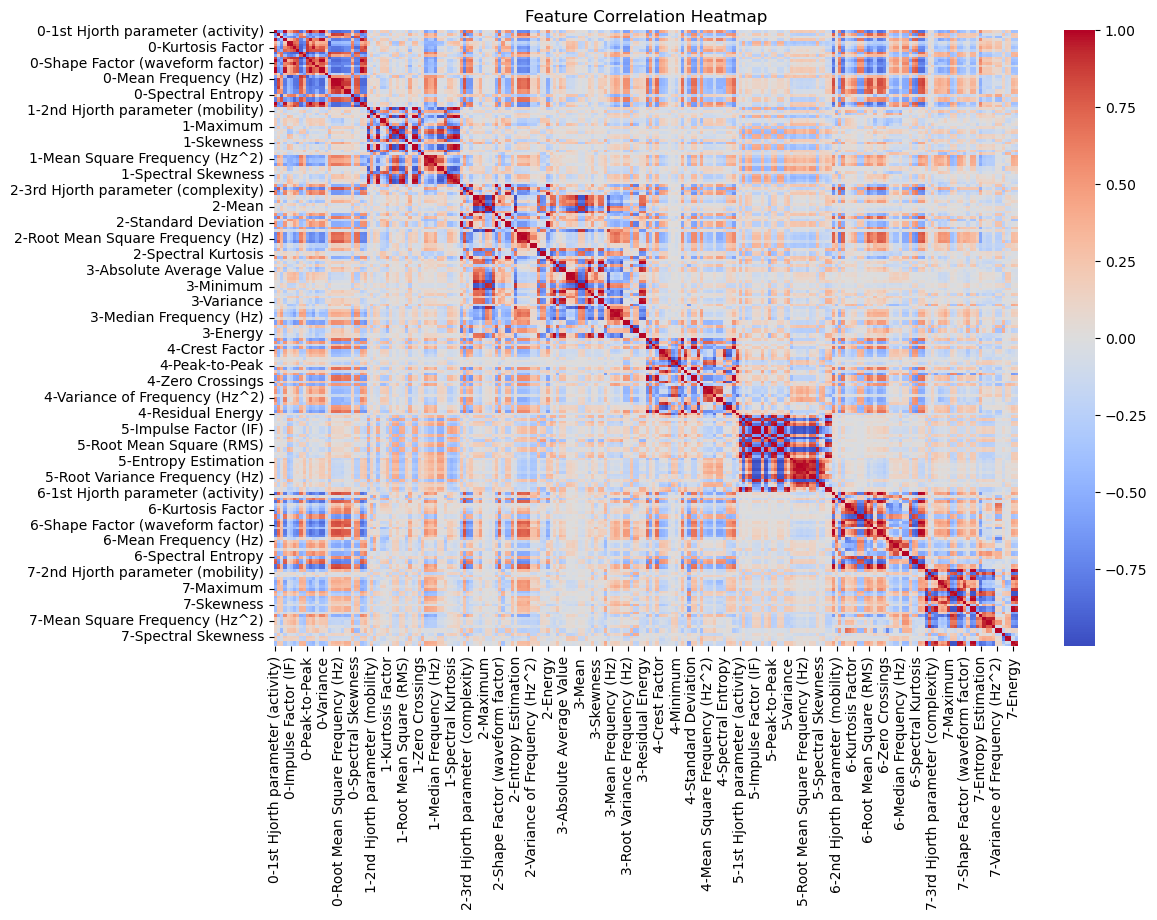

In [16]:
# Compute and visualize correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = all_features.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [17]:
# # Plot distributions for a few features
# all_features.hist(figsize=(100, 100), bins=30)
# plt.suptitle("Feature Distributions", fontsize=16)
# plt.show()

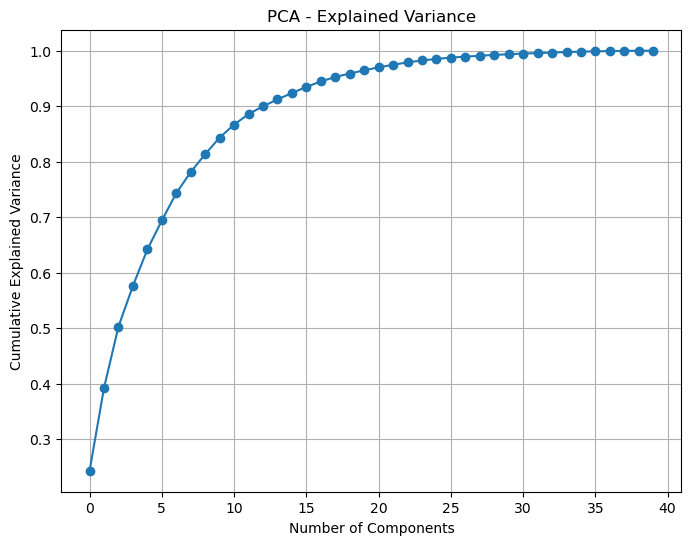

Number of components to retain 95% variance: 18


In [18]:
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(all_features)

# Perform PCA
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

# Visualize explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid()
plt.show()

# Determine the number of components to retain (e.g., 95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")


In [19]:
# Analyze feature contributions to PCA components
pca_df = pd.DataFrame(pca.components_[:n_components], columns=feature_names)
top_features = pca_df.abs().sum(axis=0).sort_values(ascending=False).head(10)
print("Top contributing features:\n", top_features)

# Select top features
selected_features = top_features.index.tolist()
reduced_data = all_features[selected_features]

Top contributing features:
 7-Skewness                             1.422719
7-Shape Factor (waveform factor)       1.394146
1-Crest Factor                         1.387645
7-Kurtosis Factor                      1.364955
7-Spectral Skewness                    1.362585
1-Impulse Factor (IF)                  1.362358
7-Spectral Kurtosis                    1.358005
0-Zero Crossings                       1.357597
4-3rd Hjorth parameter (complexity)    1.326766
4-Zero Crossings                       1.304391
dtype: float64


In [52]:
reduced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   7-Skewness                           40 non-null     float64
 1   7-Shape Factor (waveform factor)     40 non-null     float64
 2   1-Crest Factor                       40 non-null     float64
 3   7-Kurtosis Factor                    40 non-null     float64
 4   7-Spectral Skewness                  40 non-null     float64
 5   1-Impulse Factor (IF)                40 non-null     float64
 6   7-Spectral Kurtosis                  40 non-null     float64
 7   0-Zero Crossings                     40 non-null     int64  
 8   4-3rd Hjorth parameter (complexity)  40 non-null     float64
 9   4-Zero Crossings                     40 non-null     int64  
dtypes: float64(8), int64(2)
memory usage: 3.3 KB


In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import pandas as pd
import numpy as np

In [22]:
def evaluate_clustering(data, labels):
    """
    Evaluate clustering results using Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index.
    """
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    
    return {
        "Silhouette Score": silhouette,
        "Calinski-Harabasz Index": calinski_harabasz,
        "Davies-Bouldin Index": davies_bouldin,
    }


In [23]:
def evaluate_single_cluster(data, labels):
    """
    Evaluate the compactness of a single cluster using Within-Cluster Sum of Squares (WCSS).
    If DBSCAN, count noise points.
    """
    # WCSS for compactness
    if len(set(labels)) == 1:
        centroid = np.mean(data, axis=0)
        wcss = np.sum(np.linalg.norm(data - centroid, axis=1) ** 2)
        return {"WCSS (Compactness)": wcss}
    
    # For DBSCAN, evaluate number of noise points
    noise_points = sum(1 for label in labels if label == -1)
    return {"Noise Points": noise_points}


In [24]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
}
clustering_methods = {
    "KMeans": lambda data: KMeans(n_clusters=1, random_state=42).fit_predict(data),
    "AgglomerativeClustering": lambda data: AgglomerativeClustering(n_clusters=1).fit_predict(data),
    "DBSCAN": lambda data: DBSCAN(eps=0.5, min_samples=5).fit_predict(data),
    "GaussianMixture": lambda data: GaussianMixture(n_components=1, random_state=42).fit_predict(data),
}

In [25]:
# Store results
results = []

for scaler_name, scaler in scalers.items():
    scaled_data = scaler.fit_transform(all_features)
    
    for method_name, clustering_method in clustering_methods.items():
        try:
            labels = clustering_method(scaled_data)
            
            # Evaluate the method for single-cluster metrics
            scores = evaluate_single_cluster(scaled_data, labels)
            results.append({
                "Scaler": scaler_name,
                "Clustering Method": method_name,
                **scores,
            })
        except Exception as e:
            print(f"Error with {scaler_name} and {method_name}: {e}")

# Convert results to a DataFrame
results_df = pd.DataFrame(results)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Results:
            Scaler        Clustering Method  WCSS (Compactness)
4     MinMaxScaler                   KMeans        4.577983e+02
5     MinMaxScaler  AgglomerativeClustering        4.577983e+02
6     MinMaxScaler                   DBSCAN        4.577983e+02
7     MinMaxScaler          GaussianMixture        4.577983e+02
0   StandardScaler                   KMeans        9.280000e+03
1   StandardScaler  AgglomerativeClustering        9.280000e+03
2   StandardScaler                   DBSCAN        9.280000e+03
3   StandardScaler          GaussianMixture        9.280000e+03
8     RobustScaler                   KMeans        3.834146e+06
9     RobustScaler  AgglomerativeClustering        3.834146e+06
10    RobustScaler                   DBSCAN        3.834146e+06
11    RobustScaler          GaussianMixture        3.834146e+06
Results saved to 'single_cluster_results.csv'


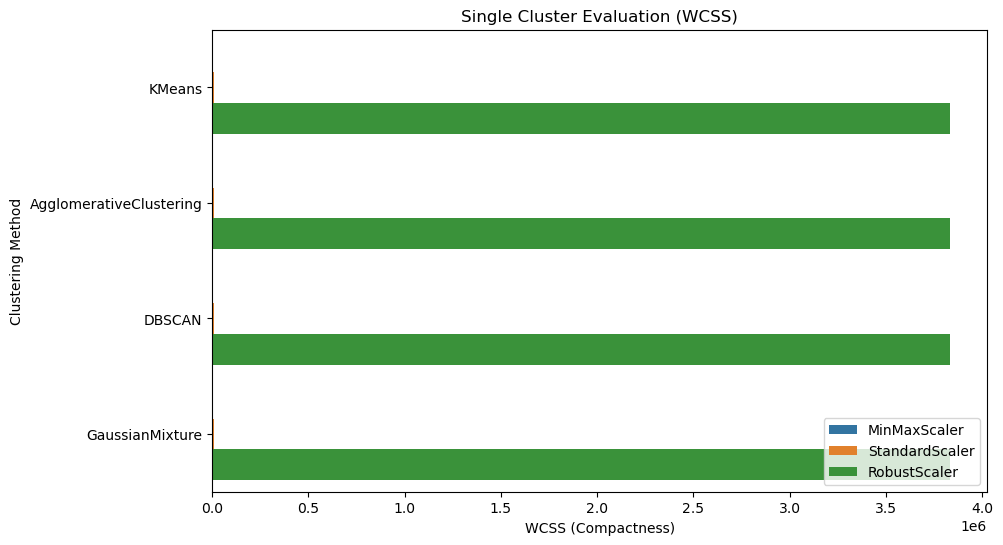

In [26]:
# Display sorted results by WCSS or Noise Points
results_df = results_df.sort_values(by="WCSS (Compactness)", ascending=True)
print("Results:")
print(results_df)

# Save results
results_df.to_csv("single_cluster_results.csv", index=False)
print("Results saved to 'single_cluster_results.csv'")

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="WCSS (Compactness)", y="Clustering Method", hue="Scaler", data=results_df)
plt.title("Single Cluster Evaluation (WCSS)")
plt.xlabel("WCSS (Compactness)")
plt.ylabel("Clustering Method")
plt.legend(loc="lower right")
plt.show()


In [27]:
unbalance_all_features = []
for i in range(len(unbalance_files)):
    feature_row = []
    for j in range(len(unbalance_files[0])):
        meta_data,signal = parse_file(unbalance_files[i][j])
        sampling_rate = calculate_sampling_rate(meta_data)
        feature_row=feature_row+list(TimeDomainFeatures(signal).all_features().values())+list(FrequencyDomainFeatures(signal,sampling_rate=sampling_rate).all_features().values())
    unbalance_all_features.append(feature_row)

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_10_25) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:10:25
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_10_25) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 13_49_56) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 13:49:56
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 13_49_56) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_13_14) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:13:14
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_13_14) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 13_52_07) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 13:52:07
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 13_52_07) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_37_13) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:37:13
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_37_13) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_17_12) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:17:12
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_17_12) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 12_57_33) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 12:57:33
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 12_57_33) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: 

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_43_06) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:43:06
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 1\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_43_06) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 13_00_31) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 13:00:31
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 13_00_31) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_22_48) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:22:48
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_22_48) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_01_11) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:01:11
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_01_11) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_25_31) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:25:31
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.02  MOTOR DE_ 2 channel vib (11-12-2024 14_25_31) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_03_46) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:03:46
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 2\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_03_46) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_53_46) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:53:46
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\MOTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.01  MOTOR FE_ 2 channel vib (11-12-2024 14_53_46) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 13_43_03) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 13:43:03
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR FREE END\TIME SIGNAL\CHANNEL 2\M-006.04  ROTOR FE_ 2 channel vib (11-12-2024 13_43_03) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring 

INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.
INFO: Initialized TimeDomainFeatures class.
INFO: Time-domain signal detected. Performing FFT.

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_08_00) - Time Signal.txt

Extracted metadata - Type: Timesignal
Extracted metadata - Date: 11-DEC-24 14:08:00
Extracted metadata - NoOfItems:  4096
Extracted metadata - Unit_Y:  mm/s
Extracted metadata - Unit_X:  Sec
Extracted metadata - Min_X:  0
Extracted metadata - Max_X:  1.60000002384186
Extracted metadata - MinDisplay_X:  0
Extracted metadata - MaxDisplay_X:  1.60000002384186

Finished parsing file: C:\Users\siris\Projects\Machine Fault Detection and Monitoring System\MFDMS\data\raw\MFFS UNBALANCE 1500 RPM\ROTOR DRIVEN END\TIME SIGNAL\CHANNEL 1\M-006.03  ROTOR DE_ 2 channel vib (11-12-2024 14_08_00) - Time Signal.txt
Metadata extracted: 9 items
Signal values extracted: 4096 items

Starting to parse file: C:\Users\siris\Projects\Machine Fault Detection and Monitor